<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [1]:
# general purpose packages
import pandas as pd
import numpy as np
import os
import sys
from datetime import datetime

# viaualization realted packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import gc

from wordcloud import WordCloud
from sklearn.manifold import TSNE

# text pre processing related packages
import re
from nltk.corpus import stopwords
# set stop words for word cloud
from wordcloud import STOPWORDS
from nltk.stem import PorterStemmer
import distance
from fuzzywuzzy import fuzz


# scaling
from sklearn.preprocessing import MinMaxScaler

# featue extraction packge for text data
from sklearn.feature_extraction.text import TfidfVectorizer

# partition the dataset to train, test
from sklearn.model_selection import train_test_split

In [2]:
print(datetime.now() ,' Started DF Geneartion')

2019-06-22 04:06:59.246211  Started DF Geneartion


# Configs

In [3]:
csv_path = '/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSets/CS07_QUORA_QUESTION_PAIR/train.csv'
sample_size = 120000 # set -1 if you want to use full dataset size

<h2> 3.1 Reading data and basic stats </h2>

In [4]:
df = pd.read_csv(csv_path, index_col=False)
print("Number of data points:",df.shape[0])
df.head()

Number of data points: 404290


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
print('Data frame info: \n', df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB
Data frame info: 
 None


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

## Deduping based on duplicate question pairs

<h3>3.2.3 Checking for Duplicates </h3>

In [6]:
print('Before deduping the data frame size :', df.shape[0])
df = df.drop_duplicates(subset=['qid1', 'qid2'])
#df = df.drop(['id'], axis=1)
print('After deduping the data frame size :', df.shape[0])

Before deduping the data frame size : 404290
After deduping the data frame size : 404290


<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

In [7]:
print('Total number of question pairs for training', df.shape[0])

Total number of question pairs for training 404290


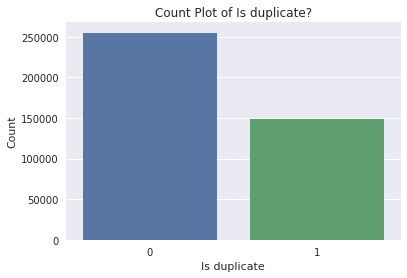

In [8]:
sns.countplot(data=df, x='is_duplicate')
plt.xlabel('Is duplicate')
plt.ylabel('Count')
plt.title('Count Plot of Is duplicate?')
plt.show()

In [9]:
count_info = df.groupby(['is_duplicate']).size()
per_array = (count_info * 100.0) / df.shape[0]

In [10]:
print('Question pairs are not Similar (is_duplicate = 0): ', per_array.loc[0])
print('Question pairs are Similar (is_duplicate = 1)', per_array.loc[1])

Question pairs are not Similar (is_duplicate = 0):  63.0802146973707
Question pairs are Similar (is_duplicate = 1) 36.9197853026293


<h3> 3.2.2 Number of unique questions </h3>

In [11]:
full_qids = df['qid1'] + df['qid2']

# all questionids unique
qids =  set(full_qids)

print('Number of unique questions:', len(qids))

# count of repetation of each question
qid_value_counts = full_qids.value_counts()
qs_more_than_once = qid_value_counts[qid_value_counts > 1]

print ('Number of questions that appeared more than once', len(qs_more_than_once), 
       (len(qs_more_than_once)/len(qids))*100.0)

print ('Max number of times a single question is repeated ', max(qid_value_counts)) 

Number of unique questions: 347345
Number of questions that appeared more than once 50205 14.453929090673537
Max number of times a single question is repeated  6


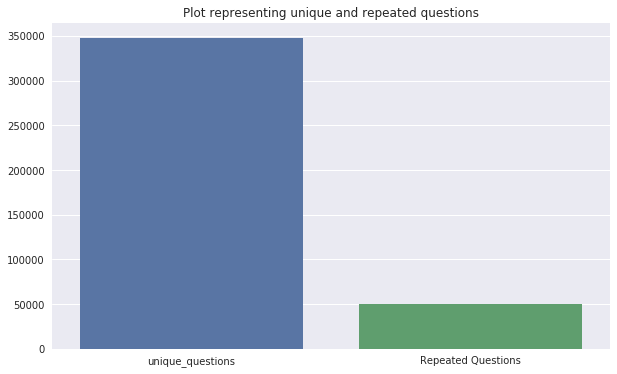

In [12]:
x = ['unique_questions' , 'Repeated Questions']
y =  [len(qids) , len(qs_more_than_once)]

plt.figure(figsize=(10, 6))
plt.title ('Plot representing unique and repeated questions')
sns.barplot(x,y)
plt.show()

<h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated : 6


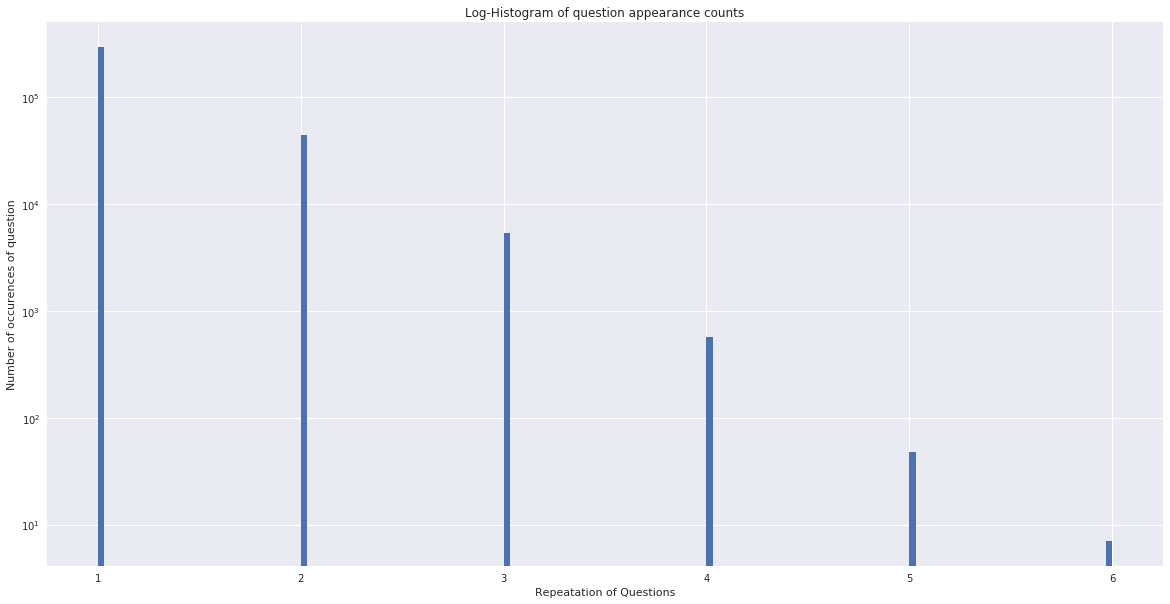

In [13]:
plt.figure(figsize=(20, 10))

plt.hist(qid_value_counts, bins=160)

plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Repeatation of Questions')
plt.ylabel('Number of occurences of question')

print ('Maximum number of times a single question is repeated :', max(qid_value_counts)) 

<h3> 3.2.5 Checking for NULL values </h3>

In [14]:
#Checking whether there are any rows with null values
null_df = df[df.isnull().any(axis=1)]
print('number of rows where nan value is present:', null_df.shape[0])
null_df.head()

number of rows where nan value is present: 3


,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


- There are two rows with null values in question2 

In [15]:
# Filling the null values with ' '
df = df.fillna('  ')
nan_rows = df[df.isnull().any(axis=1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total) 

In [16]:
def extract_feature_before_cleaning(df):
    
    print(datetime.now() ,' Extracting features before cleaning - started')
    
    # add the length of questions (number of characters)
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    
    # add the number of words in the questions
    df['q1_n_words'] = df['question1'].apply(lambda x: len(x.split(' ')))
    df['q2_n_words'] = df['question2'].apply(lambda x: len(x.split(' ')))
    
    # words in common
    q_pair_list = list(zip(df['question1'], df['question2']))
    
    # common words
    df['word_Common'] = list(map(lambda x : len(set(x[0].lower().split()) & set(x[1].lower().split())),
                                q_pair_list))
                                 
    df['word_Total'] = list(map(lambda x : len(set(x[0].lower().split())) + 
                                               len(set(x[1].lower().split())),
                               q_pair_list))
    
    # get the ratio of words shared
    df['word_share'] = df['word_Common'] / df['word_Total']
                            
    # save the file as data frame
    df.to_csv('./data/df_fe_without_preprocessing_train.csv', index=False)
    
    print(datetime.now() ,' Extracting features before cleaning - completed')
                            
    return df

In [17]:
df =  extract_feature_before_cleaning(df)
df.head()

2019-06-22 04:07:03.631548  Extracting features before cleaning - started
2019-06-22 04:07:13.086527  Extracting features before cleaning - completed


,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,10,23,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,4,20,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,4,24,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,0,19,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,2,20,0.100000


<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [18]:
min_length_q1 = df['q1_n_words'].min()
min_length_q2 = df['q2_n_words'].min()

print ("Minimum length of the questions in question1 : " , min_length_q1)
print ("Minimum length of the questions in question2 : " , min_length_q2)

print ("Number of Questions with minimum length [question1] :", 
       df[df['q1_n_words']== min_length_q1].shape[0])
print ("Number of Questions with minimum length [question2] :", 
       df[df['q2_n_words']== min_length_q2].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 66
Number of Questions with minimum length [question2] : 22


<h4> 3.3.1.1 Feature: word_share </h4>

/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



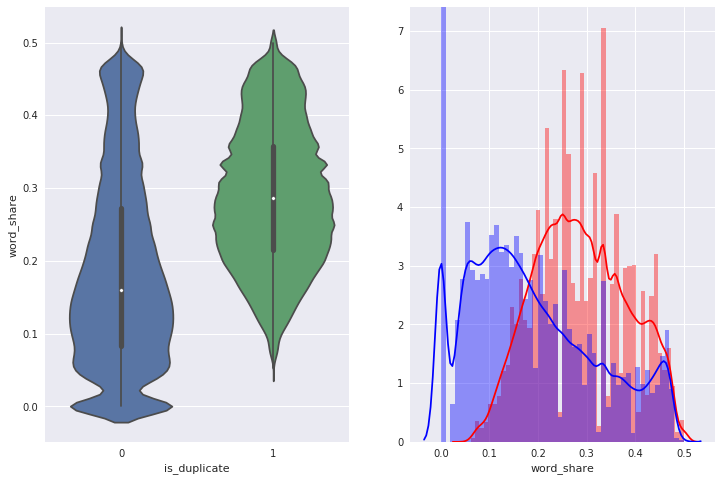

In [19]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



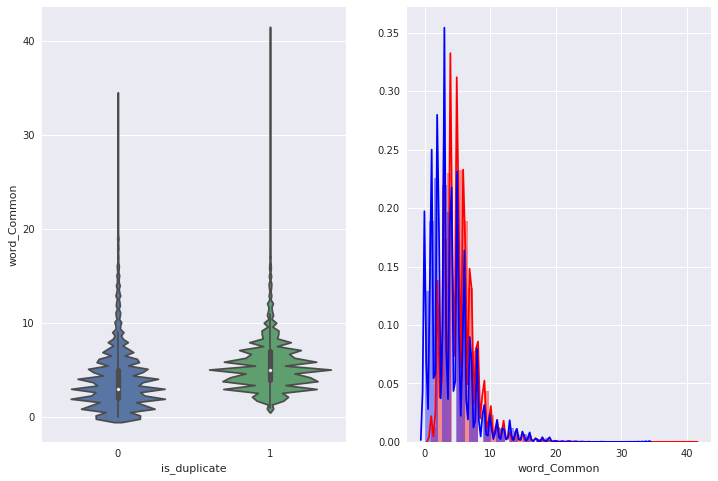

In [20]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

# Preprocessig

In [21]:
df = pd.read_csv('./data/df_fe_without_preprocessing_train.csv', index_col=False)

# take sample if opted
if sample_size > 0:
    df = df.sample(n=sample_size)

df = df.reset_index(drop=True)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share
0,126223,922,203482,Which book should I start with for the GATE pr...,Which is the best book to study the Constituti...,0,56,58,10,11,3,20,0.150000
1,125957,203109,109471,Does using apple cider vinegar for weight loss...,How do I use apple cider vinegar to lose weight?,0,70,48,12,10,3,22,0.136364
2,148615,234279,234280,Why is that sign of + used in country code in ...,Say all races and cultures are accepted in the...,0,59,96,13,16,1,28,0.035714
3,113198,185056,185057,What happens with a past curfew ticket in court?,Why do people think that the officer will not ...,0,48,85,9,17,1,26,0.038462
4,212253,317302,317303,If Microsoft didn't bundle Internet Explorer i...,Is Microsoft changing the name of Internet Exp...,0,133,52,20,8,3,26,0.115385


<h2> 3.4 Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [22]:
STOP_WORDS = stopwords.words('english')
html_tags = re.compile(r'<.*?>')
porter = PorterStemmer()

def clean_text(x):
    
    # Step 1: Remove HTML tags
    x = re.sub(html_tags, ' ', x)
    
    # Step 2: Convert to lower case
    x = x.lower()
    
    # Step 3: De-contraction of words
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    # Step 4: Removal of special characters
    special_chars_pattern = re.compile('\W')
    x = re.sub(special_chars_pattern, ' ', x)
    
    # Step 5: Removal of stop words
    #x = list(filter(lambda x: x not in STOP_WORDS, x.split(' ')))
    
    # Step 6: Stemming of words
    x = [porter.stem(item) for item in x.split()]
    x = ' '.join(x)
    
    return x 

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [23]:
def get_token_features(df):
    
    SAFE_DIV = 1e-5
    
    # convert the text to list
    question_1_txt_list = df['question1'].tolist()
    question_2_txt_list = df['question2'].tolist()
    
    # declare a list for holding all kind of token features
    token_feature_list = list()
    
    # get the features row wise
    for index in range(0, df.shape[0]):
        
        # get the tokens of both the questions individually
        q1_tokens_list = question_1_txt_list[index].split(' ')
        q2_tokens_list = question_1_txt_list[index].split(' ')
        
        # if both the list are non-empty
        if (len(q1_tokens_list) > 0  and len(q2_tokens_list) > 0):
        
            # get the stop words of both the questions individually
            q1_stopwords_set = set(filter(lambda x : x in STOP_WORDS, q1_tokens_list))
            q2_stopwords_set = set(filter(lambda x : x in STOP_WORDS, q2_tokens_list))

            # get the words of both the questions individually
            q1_words_set = set(q1_tokens_list) - q1_stopwords_set
            q2_words_set = set(q2_tokens_list) - q2_stopwords_set
            
            
            # get count of word, token, stopwords individually for each question
            q1_token_count, q2_token_count = len(q1_tokens_list), len(q2_tokens_list)
            q1_word_count, q2_word_count = len(q1_words_set), len(q2_words_set)
            q1_stopword_count, q2_stopword_count = len(q1_stopwords_set), len(q2_stopwords_set)
            
            
            # Get the common Tokens from Question pair
            common_token_count = len(set(q1_tokens_list) & set(q2_tokens_list))
            
            # Get the common non-stopwords from Question pair
            common_word_count = len(q1_words_set & q2_words_set)
    
            # Get the common stopwords from Question pair
            common_stop_count = len(q1_stopwords_set & q2_stopwords_set)

            # get individual features
            
            # Feature 1 - 
            ctc_min = common_token_count / (min(q1_token_count, q2_token_count) + SAFE_DIV)
            ctc_max = common_token_count / (max(q1_token_count, q2_token_count) + SAFE_DIV)
            
            # Feature 2 -
            cwc_min = common_word_count / (min(q1_word_count, q2_word_count) + SAFE_DIV)
            cwc_max = common_word_count / (max(q1_word_count, q2_word_count) + SAFE_DIV)
            
            # Feature 3 -
            csc_min = common_stop_count / (min(q1_stopword_count, q2_stopword_count) + SAFE_DIV)
            csc_max = common_stop_count / (max(q1_stopword_count, q2_stopword_count) + SAFE_DIV)
            
            # First word of both question is same or not
            first_word_same = int(q1_tokens_list[0] == q2_tokens_list[0])
            
            # Last word of both question is same or not
            last_word_same = int(q1_tokens_list[-1] == q2_tokens_list[-1])
    
            # absolute difference between the word count of question 1 & question 2
            abs_token_count_diff = abs(q1_token_count -q2_token_count)
    
            # Average Token Length of both Questions
            avg_token_length = (q1_token_count + q2_token_count)/2
            
            
            # form the feature vector for this data point
            feat_vector = [ctc_min, ctc_max, cwc_min, cwc_max, csc_min, csc_max,
                           first_word_same, last_word_same, abs_token_count_diff, 
                           avg_token_length]
            
            # update the data list
            token_feature_list.append(feat_vector)
            
            
        
        # if atleast one of them is empty
        else:
            token_feature_list.append([0] * 10)
            
            
            
    # form token features df
    token_feat_df = pd.DataFrame(token_feature_list, columns=['ctc_min', 'ctc_max', 
                                'cwc_min', 'cwc_max','csc_min', 'csc_max', 
                                'first_word_same', 'last_word_same', 
                                'abs_token_count_diff', 'avg_token_length'])
    
    
    return token_feat_df

In [24]:
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

In [25]:
def get_fuzzy_features(df):
    
    # declare a fuzzy feature dict
    fuzzy_feat_dict = dict()
    
    fuzzy_feat_dict['token_set_ratio'] = df.apply(
        lambda x: fuzz.token_set_ratio(x['question1'],x['question2']), axis=1)
    fuzzy_feat_dict['token_sort_ratio'] = df.apply(
        lambda x: fuzz.token_sort_ratio(x['question1'],x['question2']), axis=1)
    fuzzy_feat_dict['fuzz_ratio'] = df.apply(
        lambda x: fuzz.QRatio(x['question1'],x['question2']), axis=1)
    fuzzy_feat_dict['fuzz_partial_ratio'] = df.apply(
        lambda x: fuzz.partial_ratio(x['question1'],x['question2']), axis=1)
    fuzzy_feat_dict['longest_substr_ratio'] = df.apply(
        lambda x: get_longest_substr_ratio(x['question1'],x['question2']), axis=1)
    
    fuzzy_feat_df = pd.DataFrame(fuzzy_feat_dict, index=range(df.shape[0]))
    
    return fuzzy_feat_df

In [26]:
def get_feature_df(df):
    
    # get basic features
    basic_feat_df = df.drop(['qid1', 'qid2'], axis=1)
    
    # clean the text
    df['question1'] = df['question1'].apply(clean_text)
    df['question2'] = df['question2'].apply(clean_text)
    #df.head()

    # get token features
    token_feat_df = get_token_features(df)
    
    # get fuzzy features
    fuzzy_feat_df = get_fuzzy_features(df)

    # form the entire set of features , this data frame will have id column and labels
    # along with all the features
    
    full_feat_df = pd.concat([basic_feat_df, token_feat_df, fuzzy_feat_df], axis=1)
    
    return full_feat_df

In [27]:
full_feature_df = get_feature_df(df)
print('Full feature df shape : ', full_feature_df.shape)
full_feature_df.to_csv('./data/full_features.csv', index=False)
full_feature_df.head()

Full feature df shape :  (120000, 26)


,id,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,...,csc_max,first_word_same,last_word_same,abs_token_count_diff,avg_token_length,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,126223,Which book should I start with for the GATE pr...,Which is the best book to study the Constituti...,0,56,58,10,11,3,20,...,0.999998,1,1,0,10.0,56,52,46,46,0.117647
1,125957,Does using apple cider vinegar for weight loss...,How do I use apple cider vinegar to lose weight?,0,70,48,12,10,3,22,...,0.999990,1,1,0,12.0,77,72,64,74,0.510638
2,148615,Why is that sign of + used in country code in ...,Say all races and cultures are accepted in the...,0,59,96,13,16,1,28,...,0.999998,1,1,0,12.0,44,43,39,44,0.071429
3,113198,What happens with a past curfew ticket in court?,Why do people think that the officer will not ...,0,48,85,9,17,1,26,...,0.999998,1,1,0,9.0,55,52,45,48,0.148936
4,212253,If Microsoft didn't bundle Internet Explorer i...,Is Microsoft changing the name of Internet Exp...,0,133,52,20,8,3,26,...,0.999999,1,1,0,21.0,77,47,41,70,0.340426


<h3>3.5.1 Analysis of extracted features </h3>

<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [28]:
def plot_wordcloud(df):

    df_yes = df[df['is_duplicate'] == 1] 
    df_no = df[df['is_duplicate'] == 0] 

    print ('Number of data points in class 1 (duplicate pairs) :', df_yes.shape[0])
    print ('Number of data points in class 0 (non duplicate pairs) :', df_no.shape[0])
    
    
    print('\n\n\n')

    df_yes_sentences = df_yes['question1'] + ' ' + df_yes['question2']
    df_no_sentences = df_no['question1'] + ' ' + df_no['question2']

    df_yes_text = str()
    df_no_text = str()
    
    for ques_txt in df_yes_sentences:
        df_yes_text += ques_txt
        
    for ques_txt in df_no_sentences:
        df_no_text += ques_txt
                
    stopwords = set(STOP_WORDS)
    stopwords.remove('not')
    stopwords.remove('no')

    stopwords.add('said')
    stopwords.add('br')
    stopwords.add(' ')
    
    wc = WordCloud(background_color='white', max_words=500, stopwords=stopwords)
    wc.generate(df_yes_text)
    print ('Word Cloud for Duplicate Question pairs (YES class)')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

    wc = WordCloud(background_color='white', max_words=500, stopwords=stopwords)
    wc.generate(df_no_text)
    print ('Word Cloud for Duplicate Question pairs (YES class)')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Number of data points in class 1 (duplicate pairs) : 44304
Number of data points in class 0 (non duplicate pairs) : 75696




Word Cloud for Duplicate Question pairs (YES class)


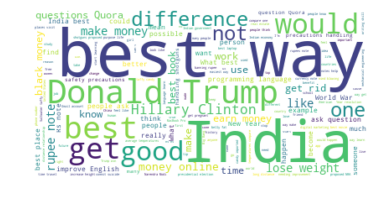

Word Cloud for Duplicate Question pairs (YES class)


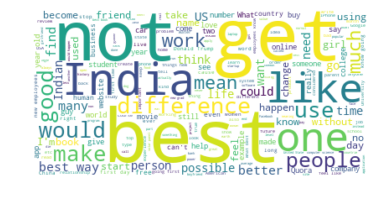

In [29]:
plot_wordcloud(full_feature_df)

<ul>
<li>The word India is present both in duplicate & non-duplicate data </li>
<li> The words Donald Trump, best way are the two frequently occuring word in YES class data </li>
<li> The word best, get , not are the most frequently occuring words in NO class </li>
</ul>

In [30]:
stopwords = set(STOPWORDS)
stopwords.remove('not')
stopwords.remove('no')

stopwords.add('said')
stopwords.add('br')
stopwords.remove('like')
stopwords.add(' ')

__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs (YES class)


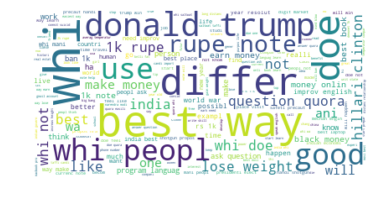

In [31]:
pos_df = df[df['is_duplicate'] == 1]
textp_w = pos_df['question1'] + ' ' + pos_df['question2']
textp_w = ' '.join(list(textp_w))

wc = WordCloud(background_color='white', max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ('Word Cloud for Duplicate Question pairs (YES class)')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs (NO class)


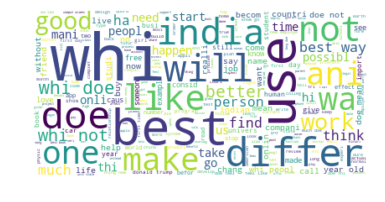

In [32]:
neg_df = df[df['is_duplicate'] == 0]
textn_w = neg_df['question1'] + ' ' + neg_df['question2']
textn_w = ' '.join(list(textn_w))

wc = WordCloud(background_color='white', max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ('Word Cloud for non-Duplicate Question pairs (NO class)')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [33]:
full_feature_df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']].head()

,ctc_min,cwc_min,csc_min,token_sort_ratio,is_duplicate
0,0.999999,0.999998,0.999998,52,0
1,0.999999,0.999999,0.999990,72,0
2,0.916666,0.999999,0.999998,43,0
3,0.999999,0.999998,0.999998,52,0
4,0.904761,0.999999,0.999999,47,0


3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']

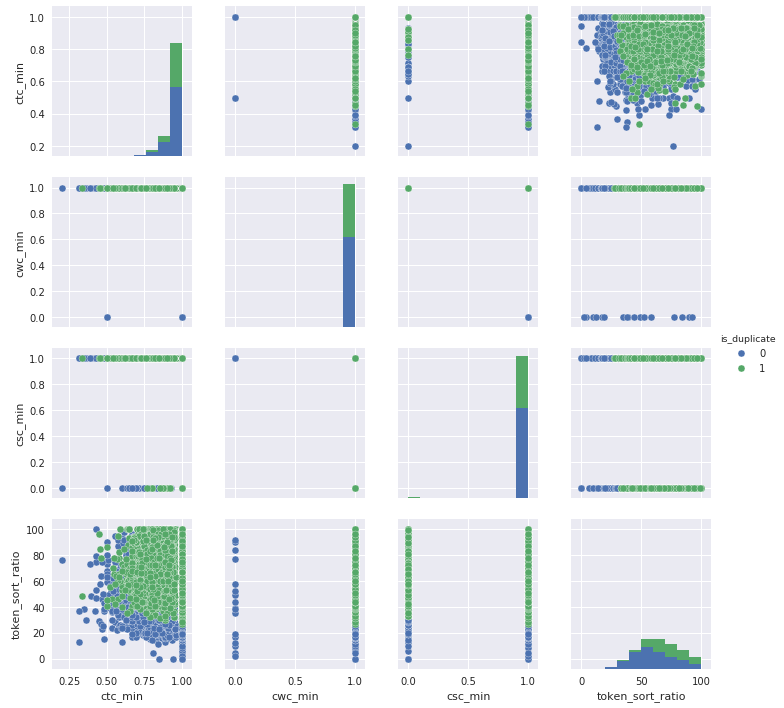

In [34]:
sns.pairplot(full_feature_df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']],
             hue='is_duplicate', 
             vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

<ul>
<li> No correlation is identified for any pair of features </li>
</ul>

/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



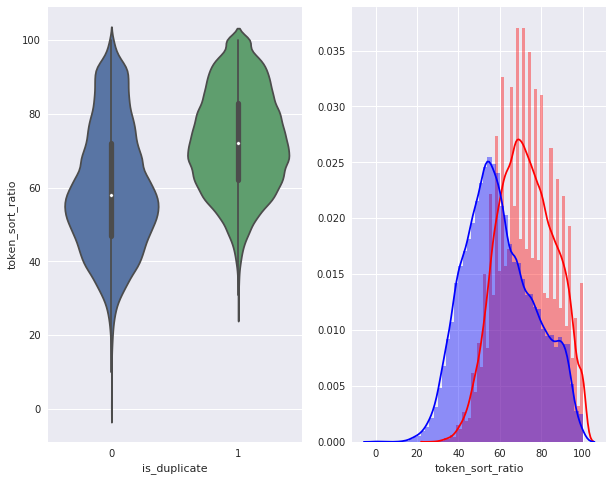

In [35]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = full_feature_df , )

plt.subplot(1,2,2)
sns.distplot(full_feature_df[full_feature_df['is_duplicate'] == 1]['token_sort_ratio'], 
             label='1', color='red')
sns.distplot(full_feature_df[full_feature_df['is_duplicate'] == 0]['token_sort_ratio'], 
             label='0' , color='blue' )
plt.show()

<ul>
<li> The Q2 value of token sort ratio differs a lot between YES & NO class</li>
<li> The PDF plot shows a slight shift in mean towards right for the YES class</li>
</ul>

/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



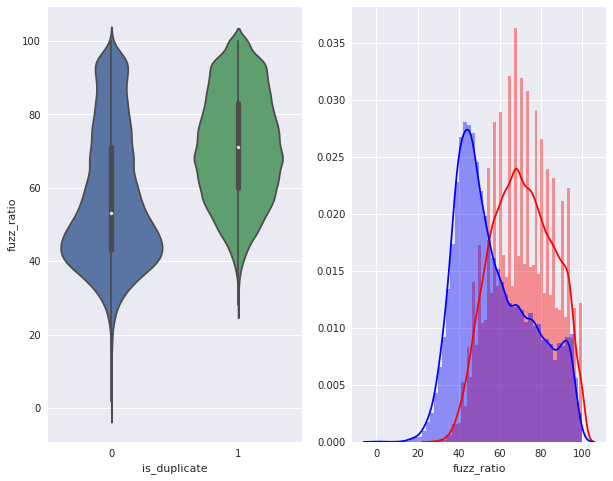

In [36]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x ='is_duplicate', y ='fuzz_ratio', data=full_feature_df)

plt.subplot(1,2,2)
sns.distplot(full_feature_df[full_feature_df['is_duplicate'] == 1]['fuzz_ratio'], 
             label='1', color='red')
sns.distplot(full_feature_df[full_feature_df['is_duplicate'] == 0]['fuzz_ratio'], 
             label='0', color='blue')
plt.show()

<ul>
<li> The Q2 value of fuzz_ratio differs a lot between YES & NO class</li>
<li> The PDF plot shows a slight shift in mean towards right for the YES class</li>
</ul>

3.5.2 Visualization

In [37]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention
df_sample = full_feature_df.sample(frac=1.0)

X = MinMaxScaler().fit_transform(df_sample[['ctc_min', 'ctc_max', 'cwc_min', 'cwc_max','csc_min', 'csc_max', 
                                            'first_word_same', 'last_word_same', 'abs_token_count_diff', 
                                            'avg_token_length', 'token_set_ratio', 'token_sort_ratio', 
                                            'fuzz_ratio','fuzz_partial_ratio', 'longest_substr_ratio']])
y = df_sample['is_duplicate'].values

In [38]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120000 samples in 0.925s...
[t-SNE] Computed neighbors for 120000 samples in 85.816s...
[t-SNE] Computed conditional probabilities for sample 1000 / 120000
[t-SNE] Computed conditional probabilities for sample 2000 / 120000
[t-SNE] Computed conditional probabilities for sample 3000 / 120000
[t-SNE] Computed conditional probabilities for sample 4000 / 120000
[t-SNE] Computed conditional probabilities for sample 5000 / 120000
[t-SNE] Computed conditional probabilities for sample 6000 / 120000
[t-SNE] Computed conditional probabilities for sample 7000 / 120000
[t-SNE] Computed conditional probabilities for sample 8000 / 120000
[t-SNE] Computed conditional probabilities for sample 9000 / 120000
[t-SNE] Computed conditional probabilities for sample 10000 / 120000
[t-SNE] Computed conditional probabilities for sample 11000 / 120000
[t-SNE] Computed conditional probabilities for sample 12000 / 120000
[t-SNE] Computed conditional probab

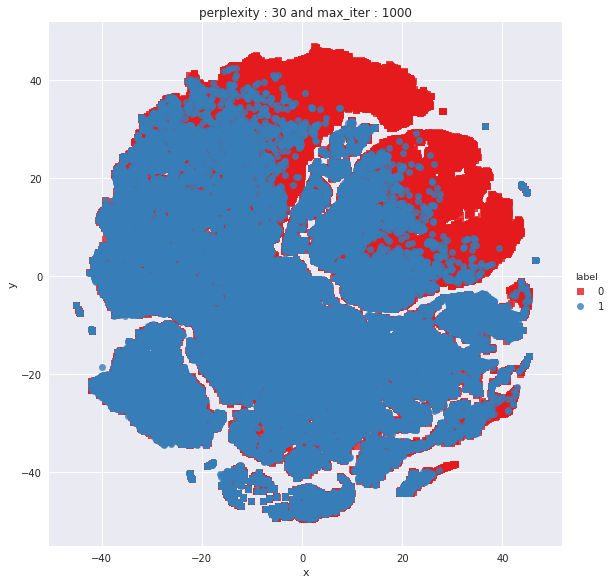

In [39]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, 
           size=8, palette='Set1', markers=['s','o'])
plt.title('perplexity : {} and max_iter : {}'.format(30, 1000))
plt.show()

<ul>
<li> From the above t-SNE plot many +ve , -ve datapoints are highly overlapping</li>
<li> There moderately large red points which can be separated well from the rest of the points</li>
<li> Need to try complicated models to separate out the points</li>
</ul>

# Vectorizer

In [42]:
def get_vectorized_data(df):
    
    df_train, df_test = train_test_split(df, stratify=df['is_duplicate'], 
                                     test_size=0.30, shuffle=True)
    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    # merge texts
    questions = list(df_train['question1']) + list(df_train['question2'])

    # Declare a text vectorizer
    tfidf_q1 = TfidfVectorizer(lowercase=False, min_df=0.01, max_df=0.95, 
                            max_features=4000, stop_words=set(STOP_WORDS))
    tfidf_q2 = TfidfVectorizer(lowercase=False, min_df=0.01, max_df=0.95, 
                            max_features=4000, stop_words=set(STOP_WORDS))
    
    # fit to questions 1, 2 separately
    tfidf_q1.fit(df_train['question1'])
    tfidf_q2.fit(df_train['question2'])
    
    # get the feature names as a list
    q1_feature_columns = ['q1_' + item for item in list(tfidf_q1.get_feature_names())]
    q2_feature_columns = ['q2_' + item for item in list(tfidf_q2.get_feature_names())]
    
    
    # vectorize the train data
    train_ques1_feature = tfidf_q1.transform(df_train['question1'])
    train_ques2_feature = tfidf_q2.transform(df_train['question2'])
    
    test_ques1_feature = tfidf_q1.transform(df_test['question1'])
    test_ques2_feature = tfidf_q2.transform(df_test['question2'])
    
    # get the vectorized outputs
    train_ques1_feature_df = pd.DataFrame(train_ques1_feature.toarray(), 
                                          columns=q1_feature_columns)
    train_ques2_feature_df = pd.DataFrame(train_ques2_feature.toarray(), 
                                          columns=q2_feature_columns)
    test_ques1_feature_df = pd.DataFrame(test_ques1_feature.toarray(), 
                                          columns=q1_feature_columns)
    test_ques2_feature_df = pd.DataFrame(test_ques2_feature.toarray(), 
                                          columns=q2_feature_columns)
    
    
    # get the other features
    df_train = df_train.drop(['question1', 'question2'], axis=1)
    df_test = df_test.drop(['question1', 'question2'], axis=1)
    
    # concate the data frames 
    df_train = pd.concat([df_train, train_ques1_feature_df, train_ques2_feature_df], 
                         axis=1)
    df_test = pd.concat([df_test, test_ques1_feature_df, test_ques2_feature_df], 
                        axis=1)
    
    # save files to disk
    df_train.to_csv('./data/Final_train_df.csv', index=False)
    df_test.to_csv('./data/Final_test_df.csv', index=False)

In [43]:
get_vectorized_data(full_feature_df)

In [44]:
df_train = pd.read_csv('./data/Final_train_df.csv', index_col=False)
df_train.head()

,id,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,ctc_min,...,q2_start,q2_think,q2_time,q2_use,q2_want,q2_way,q2_without,q2_work,q2_would,q2_year
0,223477,0,73,61,12,13,2,23,0.086957,0.999999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,111372,0,32,40,6,6,3,12,0.250000,0.999998,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,291123,0,67,46,13,10,2,22,0.090909,0.923076,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,317134,1,33,37,7,6,4,13,0.307692,0.999999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,246990,0,94,58,16,10,1,25,0.040000,0.937499,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
df_train.shape

(84000, 123)

In [46]:
print(datetime.now() ,' Completed DF Geneartion')

2019-06-22 08:51:22.041387  Completed DF Geneartion


# Procedure Summary

<ul>
<li> Deduping of the dataset is done </li>
<li> Basic EDA such as count, distribution of clasess on the dataset is done</li>
<li> NLP preprocessing is done on text data </li>
<li> Fuzzy-Wuzzy features , Token set featues are genered for every data point. </li>
<li> Most frequently occuring words for each class is identified and shown in word cloud </li>
<li> TF-IDF vectorizer is used to vectorize the text </li>
<li> Train, Test data set is prepared for the models </li>
</ul>

# Conclusion

<ul>
<li> Basic EDA is done on the dataset </li>
<li> Vectorization of text data is done </li>
<li> Train, test dataset is prepared</li>
</ul>